<a href="https://colab.research.google.com/github/RenYuanXue/LearningBERT/blob/main/Fine_Tuning_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load CoLA Dataset

Get wget package to download the dataset

In [25]:
!pip install wget

Download the zip file using wget

In [26]:
import wget
import os

print('Downloading dataset...')

# The url for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
  wget.download(url, './cola_public_1.1.zip')

Unzip the dataset to file system

In [27]:
# Unzip the dataset (if we haven't done so).
if not os.path.exists('./cola_public/'):
  !unzip cola_public_1.1.zip

Load the dataset to pandas dataframe

In [28]:
import pandas as pd

# Load data to pandas dataframe.
df = pd.read_csv('./cola_public/raw/in_domain_train.tsv',
          delimiter = '\t', header = None,
          names = ['sentence_source', 'label', 'label_notes', 'sentence'])

# Report number of sentences in the dataframe.
print('Number of training sentences: {0}'.format(df.shape[0]))

# Display first few rows from the data.
df.head()

Number of training sentences: 8551


,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


If the sentence is grammatically correct, it is labelled as 1, otherwise 0.

Extract the sentences and labels used for BERT.

In [29]:
sentences = df.sentence.values
labels = df.label.values

## Tokenization & input formatting

Get transformers library in case don't have it.

In [30]:
!pip install transformers

First, we need to load the BERT tokenizer.

In [31]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Apply the tokenizer to our input sentences.

In [32]:
# Print original sentence.
print('Original: ', sentences[0])

# Print splitted sentences as tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print sentences mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


Use tokenizer encode function to encode sentences. However, it only takes care of truncating, not padding.

In [33]:
# Save mapped sentences.
input_ids = []

# Loop through all sentences.
for sentence in sentences:
  # The function encode will:
  # 1. Map each word to corresponded ids.
  # 2. Append [SEP] at end of each sentence.
  # 3. Prepand [CLS] to start of each sentence.
  # 4. Map tokens to their IDs.
  encoded_sentence = tokenizer.encode(
              sentence,
              add_special_tokens = True # Add [SEP] and [CLS]
              # max_length = 128, # Truncate all sentences.
              # return_tensors = 'pt' # Return pytorch tensors.
            )
  input_ids.append(encoded_sentence)

Now we need to padding and truncating. Find the maximum sentence length.

In [34]:
print('Max sentence length: {0}'.format(max([len(sentence) for sentence in input_ids])))

Max sentence length: 47


Therefore we choose max_length = 64, since 32 < 47 < 64.

In [35]:
# Use Keras to do the padding.
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64

input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype = "long",
              value = 0, truncating = 'post', padding = 'post')

Now, create attention masks.

In [36]:
attention_masks = []

for sentence in input_ids:
  curr_mask = [int(token_id > 0) for token_id in sentence]

  attention_masks.append(curr_mask)

Make train and validation splits using sklearn.

In [37]:
from sklearn.model_selection import train_test_split

# 90% Train, 10% Validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                            random_state = 2018, test_size = 0.1)

# Do the same for masking.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                              random_state = 2018, test_size = 0.1)

Now, convert all used inputs to torch tensors.

In [38]:
import torch

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

Lastly, we use torch's DataLoader to make batches of inputs.

In [39]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create DataLoader for training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

# Create DataLoader for validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)

## Train Classification Model

In [40]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load the pretrained BERT model with single linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # 12 layer BERT model, with an uncased vocab.
    # num_labels = 2, # Number of output labels = 2, binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False # Whether the model returns all hidden states.
)

# Let Pytorch to run the model on GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('The model will run on GPU') if torch.cuda.is_available() else print('The model will run on CPU')
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The model will run on GPU


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Create optimizer & learing rate scheduler

In [41]:
optimizer = AdamW(model.parameters(),
          lr = 2e-5, # Default is 5e-5.
          eps = 1e-8 # Default is 1e-8.
        )

In [42]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs.
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler. The learning rate will decrease as epochs increase.
scheduler = get_linear_schedule_with_warmup(optimizer,
                       num_warmup_steps = 0,
                       num_training_steps = total_steps)

Helper function 1: calculate accuracy.

In [43]:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis = 1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function 2: format elapsed times.

In [44]:
import time
import datetime

def format_time(elapsed):
  # Round to nearest second.
  elapsed_rounded = int(round(elapsed))

  # Format as hh:mm:ss.
  return str(datetime.timedelta(seconds = elapsed_rounded))

Set seed value for reproducible results.

In [45]:
import random

# Set seed value for reproducible results.
seed_num = 42

random.seed(seed_num)
np.random.seed(seed_num)
torch.manual_seed(seed_num)
torch.cuda.manual_seed_all(seed_num)

Main train loop.


In [46]:
loss_values = []
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

for epoch_i in range(0, epochs):

  # =====================================
  #       Training
  # =====================================

  print("")
  print('====== Epoch {:} / {:} ======'.format(epoch_i + 1, epochs))
  print('Running Training...')

  t0 = time.time()

  # Reset loss at start of every loop.
  total_loss = 0

  # This code doesn't train the model automatically.
  # This code only put model in training mode.
  # Because 'dropout' and 'batchnorm' layers perform differently during train v.s test.
  model.train()

  # For each batch in training data...
  for step, batch in enumerate(train_dataloader):
  
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print(' Brach {:<5} of {:>5}, Elapsed:{:}.'.format(step, len(train_dataloader), elapsed))

    # batch contains 3 pytorch tensors:
    # [0]: input ids.
    # [1]: attention masks.
    # [2]: labels.
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Always clear previous gradients.
    # Pytorch doesn't do this automatically,
    # because in some networks it's helpful to keep previous gradients.
    model.zero_grad()

    outputs = model(b_input_ids,
             token_type_ids = None,
             attention_mask = b_input_mask,
             labels = b_labels)
    
    loss = outputs.loss

    # Accumulate loss values.
    total_loss += loss.item()

    # Perform a backward pass to calculate gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradients.
    optimizer.step()

    # Update learning rate.
    scheduler.step()

  # Calculate the average loss over the training data.
  avg_train_loss = total_loss / len(train_dataloader)

  # Store the loss value for plotting the learning curve.
  loss_values.append(avg_train_loss)

  # Measure how long this epoch took.
  training_time = format_time(time.time() - t0)

  print("")
  print(" Average training loss: {0:.2f}".format(avg_train_loss))
  print(" Traing epoch took: {:}".format(format_time(time.time() - t0)))

  # =====================================
  #       Validation
  # =====================================

  print("")
  print("Runing Validation ...")

  t0 = time.time()

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Tracking variables 
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
      
    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using 
    # the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():        

      # Forward pass, calculate logit predictions.
      # token_type_ids is the same as the "segment ids", which 
      # differentiates sentence 1 and 2 in 2-sentence tasks.
      result = model(b_input_ids, 
              token_type_ids=None, 
              attention_mask=b_input_mask,
              labels=b_labels,
              return_dict=True)
      
    # Get the loss and "logits" output by the model. The "logits" are the 
    # output values prior to applying an activation function like the 
    # softmax.
    loss = result.loss
    logits = result.logits
            
    # Accumulate the validation loss.
    total_eval_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    total_eval_accuracy += flat_accuracy(logits, label_ids)

  # Report the final accuracy for this validation run.
  avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(validation_dataloader)
    
  # Measure how long the validation run took.
  validation_time = format_time(time.time() - t0)
    
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

  # Record all statistics from this epoch.
  training_stats.append(
      {
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
        'Training Time': training_time,
        'Validation Time': validation_time
      }
    )
  
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


====== Epoch 1 / 4 ======
Running Training...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


 Brach 40    of   241, Elapsed:0:00:09.
 Brach 80    of   241, Elapsed:0:00:17.
 Brach 120   of   241, Elapsed:0:00:26.
 Brach 160   of   241, Elapsed:0:00:34.
 Brach 200   of   241, Elapsed:0:00:43.
 Brach 240   of   241, Elapsed:0:00:51.

 Average training loss: 0.51
 Traing epoch took: 0:00:51

Runing Validation ...
  Accuracy: 0.77
  Validation Loss: 0.53
  Validation took: 0:00:02

====== Epoch 2 / 4 ======
Running Training...
 Brach 40    of   241, Elapsed:0:00:08.
 Brach 80    of   241, Elapsed:0:00:17.
 Brach 120   of   241, Elapsed:0:00:25.
 Brach 160   of   241, Elapsed:0:00:34.
 Brach 200   of   241, Elapsed:0:00:42.
 Brach 240   of   241, Elapsed:0:00:51.

 Average training loss: 0.32
 Traing epoch took: 0:00:51

Runing Validation ...
  Accuracy: 0.82
  Validation Loss: 0.47
  Validation took: 0:00:02

====== Epoch 3 / 4 ======
Running Training...
 Brach 40    of   241, Elapsed:0:00:08.
 Brach 80    of   241, Elapsed:0:00:17.
 Brach 120   of   241, Elapsed:0:00:25.
 Brach 1

Create dataframe from the statistics.

In [48]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.51,0.53,0.77,0:00:51,0:00:02
2,0.32,0.47,0.82,0:00:51,0:00:02
3,0.20,0.50,0.83,0:00:51,0:00:02
4,0.14,0.58,0.83,0:00:51,0:00:02


View the training and validation loss in pyplot.

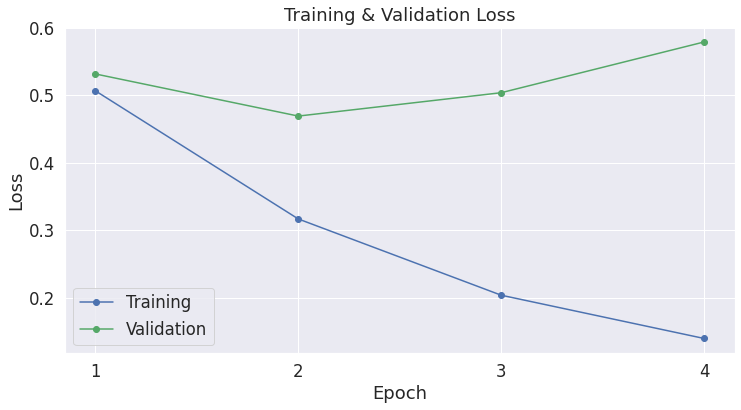

In [49]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Performance on Test Set

Data preparation

In [50]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Number of test sentences: 516



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Evaluation on test set.

In [52]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


Accuracy on CoLA benchmark is measured using "Matthews correlation coefficient" (MCC), used when classes are imbalanced.

In [53]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [54]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Take a look at the variabilities of MCC between batches.

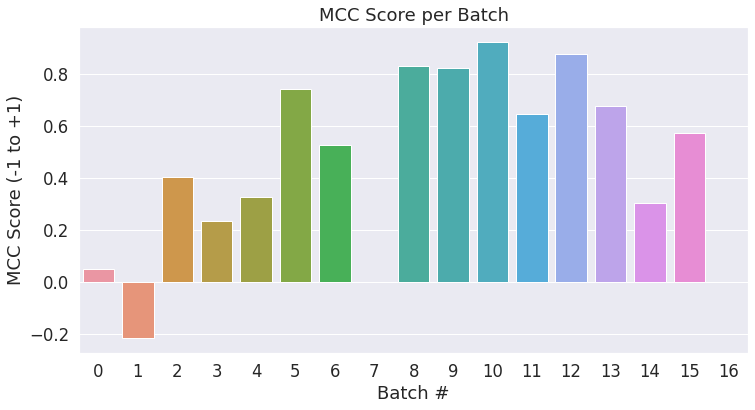

In [55]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Combine the results fro all batches and calculate the final MCC score.

In [58]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.545


### Appendix

Save the model in colab.

In [65]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

Save the model to google drive.

In [66]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# Copy the model files to a directory in your Google Drive.
!cp -r './model_save/' "./drive/MyDrive/Google Colab Files/BERT Fine-Tuning/"

The huggingface example includes the following code block for enabling weight decay, but the default decay rate is "0.0", so I moved this to the appendix.

This block essentially tells the optimizer to not apply weight decay to the bias terms (e.g., $ b $ in the equation $ y = Wx + b $ ). Weight decay is a form of regularization--after calculating the gradients, we multiply them by, e.g., 0.99.

In [70]:
# This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
no_decay = ['bias', 'LayerNorm.weight']

# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

NameError: ignored